# Telco Churn Project
## Final Report

## Goals
* Discover account features that provide predictve value for customer churn
* Provide a model for use in predicting which customers will likely churn
* Provide recomendations to stakeholders for reducing churn

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import scipy.stats as stats
import seaborn as sns
import env
import os
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import acquire
import prepare
import explore

## Acquire

* Data acquired from the Codeup DB Server
* It contained 7043 rows and 25 columns before cleaning
* The data was aquired on 25 APR 2023
* Each row represents a unique Telco customer account
* Each column represents a feature of those accounts


## Prepare
* This step involved to iterations
* Iniitial preperation
    * Removed columns that did not contain useful information
    * Checked that column data types were appropriate
        * The total_charges column was modified from a string to a float
    * Checked for null values
        * Null values in total_charges were replaced with a '0', because they represented new accounts that had not been charged yet
    * Dummy columns were created for modeling
    * Renamed columns to promote readability
* Second iteration - post evaluation
    * Removed all feature columns that did not provide predictive value
    * Removed duplicated features 
    * Removed dummy columns that were not needed
    * Outliers have not been removed for any iteration of the project

### Data Dictionary

| Feature | Key | Data Type | Definition |
|---|---|---|---|
| customer_id | Unique ID | object | identifier for each individual customer's account |
| gender | Male/Female | object | Whether the client is a female or a male |
| senior_citizen | 1 = Yes 2 = No | int64 | Whether the client is a senior citizen or not |
| partner | Yes or No | object | Whether the client has a partner or not |
| dependents | Yes or No | object | Whether the client has dependents or not |
| tenure | Months | int64 | Number of months the customer has stayed with the company |
| phone_service | Yes or No | object | Whether the client has a phone service or not |
| multiple_lines | No phone service <br>No<br>Yes | object | Whether the client has multiple lines or not |
| online_security | 7043 non-null | object | Whether the client has online security or not |
| online_backup | 7043 non-null | object | Whether the client has online backup or not |
| device_protection | 7043 non-null | object | Whether the client has device protection or not |
| tech_support | No internet service<br>No<br>Yes | object | Whether the client has tech support or not |
| streaming_tv | No internet service<br>No<br>Yes | object | Whether the client has streaming TV or not |
| streaming_movies | No internet service<br>No<br>Yes | object | Whether the client has streaming movies or not |
| paperless_billing | Yes or No | object | Whether the client has paperless billing or not |
| monthly_charges | in USD | float64 | The amount charged to the customer monthly |
| total_charges | in USD | object | The total amount charged to the customer |
| churn (Target Feature) | Yes or No | object | Has the client churned or not |
| contract_type | Month-to-Month<br>One year<br>Two year | object | Indicates the customer’s current contract type |
| internet_service_type | DSL<br>Fiber optic<br>No | object | Whether the client is subscribed to Internet service with the company |
| payment_type | Electronic check<br>Mailed check<br>Bank transfer (automatic)<br>Credit Card (automatic) | object | The customer’s payment method |
|  |  |  |  |

### Bring in Data for Exploration

In [2]:
# Acquiring data
df = acquire.get_telco_data()
# Running initial preperation for exploration
df = prepare.prep_telco(df)
# Split
train, validate, test = prepare.split_data(df,'churn')

### Sneak Peak at the Data


In [3]:
train.head(3)

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),electronic_check,payment_type_Mailed check
5911,5911,8319-QBEHW,Male,0,No,Yes,26,No,No phone service,No,...,0,1,0,1,0,0,0,0,0,0
2479,2479,3547-LQRIK,Female,0,Yes,No,47,Yes,Yes,No internet service,...,0,0,0,1,0,0,1,0,1,0
5889,5889,8280-MQRQN,Female,0,No,No,1,Yes,No,No,...,0,1,1,0,0,0,0,0,0,1


### Summary of Data

In [4]:
train.describe()

,Unnamed: 0,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,tech_support_No internet service,tech_support_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),electronic_check,payment_type_Mailed check
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,...,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,3483.374911,0.161893,32.500828,65.056142,2298.513598,0.508639,0.488521,0.306272,0.218462,0.289467,...,0.395503,0.593846,0.265325,0.216095,0.235503,0.439053,0.218462,0.217515,0.336805,0.224852
std,2035.901018,0.368397,24.532563,30.268493,2271.603284,0.499985,0.499927,0.460999,0.413251,0.453569,...,0.489016,0.491172,0.441559,0.411628,0.424363,0.496330,0.413251,0.412604,0.472673,0.417534
min,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1695.000000,0.000000,9.000000,35.650000,411.600000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3476.000000,0.000000,29.000000,70.400000,1401.150000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5224.000000,0.000000,55.000000,90.150000,3865.450000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,7042.000000,1.000000,72.000000,118.750000,8672.450000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploration

* I divided all the features in related groups for charting and evaluations
* All features independently charted against churn
* alpha =.05 for all satistics ran
* For Relevant catagorical features $\chi^2$ was used
* For numerical features T-tests were used

### 1. Do any of the demographic features provide relevant preditive value for churn?

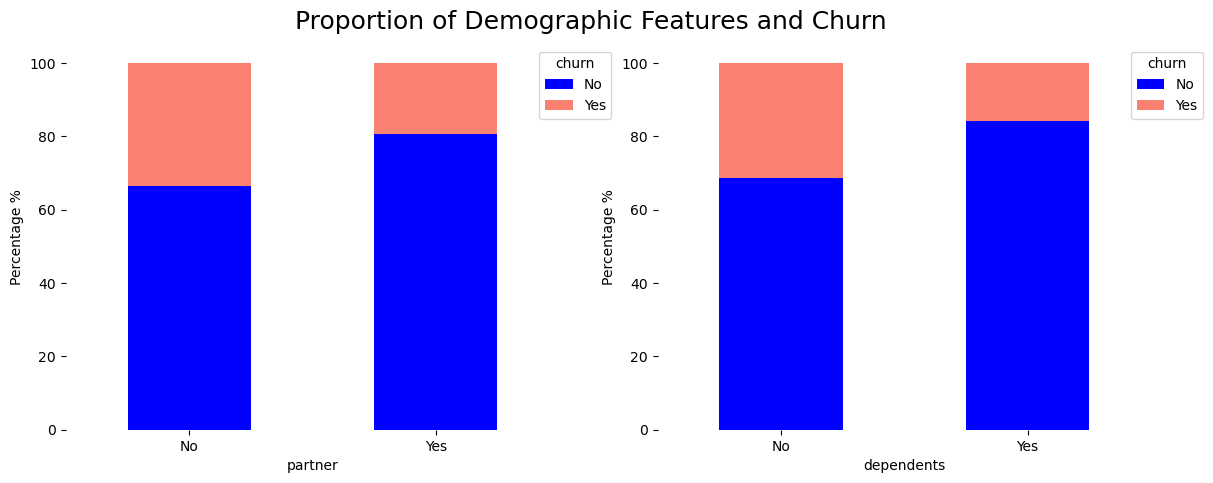

In [5]:
# Get visualizaions
explore.get_charts_demographics(train)

#### Charting Observations: Demographic Features
* gender appears to have no impact
* senior citizens appear to churn less
    * however, they only make up 16.21% of observation making it an unreliable predictor over all

####  Statistics: Demographics
Lets use $\chi^2$ for remaining demographics: partner and dependents
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for partner (marital status)
$H_0$ : Churn is independent of marital status<br>
$H_a$ : Churn is dependent of marital status

In [6]:
# Running stat test
explore.get_partner_chi(train)

alpha = 0.05
chi^2 = 106.6312
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the partner.
 Therefore, we reject the Ho


##### Hypothisis for dependents
$H_0$ : Churn is independent on whether or not customers have dependents<br>
$H_a$ : Churn is dependent on whether or not customers have dependents

In [7]:
# Running stat test
explore.get_dependents_chi(train)

alpha = 0.05
chi^2 = 111.7405
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the dependents.
 Therefore, we reject the Ho


#### Result
Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'dependents' and 'partner' are statisically relevant and will have some positive impact on the model.

### 2. Do catagorical customer account features provide relevant predictive value for churn?

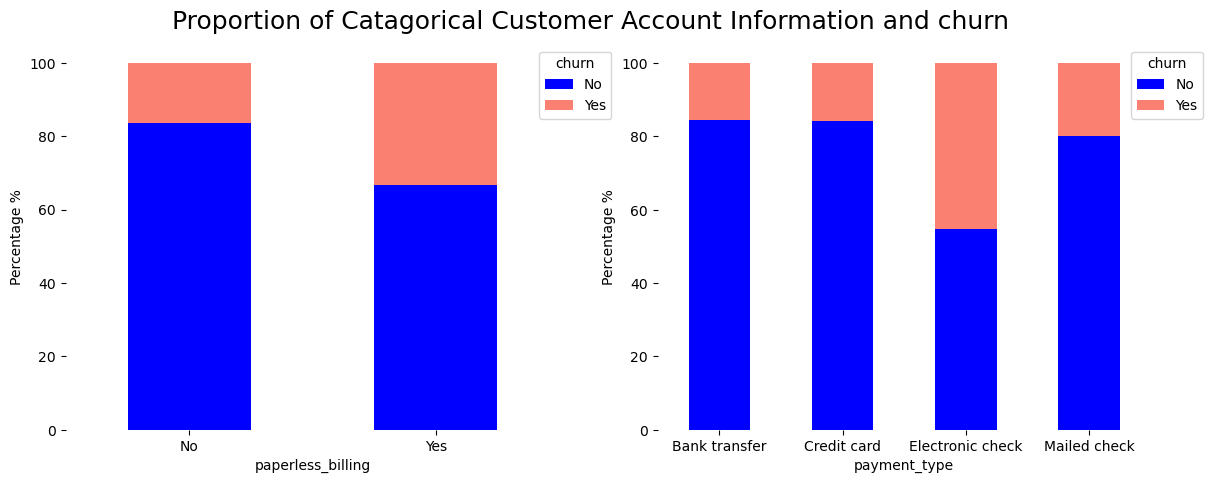

In [8]:
# Get visualizaions
explore.get_charts_cat_account(train)

#### Charting Observations: Catagorical Account Info
* Month-to-month contracts have higher churn rates compared to clients with yearly contracts
    * This makes since contracts create a barrier to churn 
    * This option is not likely to go away, but there is cause to promote contracts to M2M customers
* Customers with electronic check as paying method are more likely to leave the company
    * Other payment types are all the same
* Customers with paperless billing churn more often

#### Statistics: Catagorical Customer Account Information 
Lets use $\chi^2$ on the remaining features: paperless_billing and payment_type_electronic_check
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for paperless_billing
$H_0$ : Churn is independent of paperless_billing<br>
$H_a$ : Churn is dependent of paperless_billing

In [9]:
# Running stat test
explore.get_paperless_billing_chi(train)

alpha = 0.05
chi^2 = 148.5845
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the paperless_billing.
 Therefore, we reject the Ho


##### Hypothisis for electronic_check
$H_0$ : Churn is independent of electronic_check<br>
$H_a$ : Churn is dependent of electronic_check

In [10]:
# Running stat test
explore.get_electronic_check_chi(train)         

alpha = 0.05
chi^2 = 381.5760
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the electronic_check.
 Therefore, we reject the Ho


#### Result
* Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'paperless_billing' and 'electronic_check' are statisically relevant will have some positive impact on the model.

### 3. Do numerical customer account features provide relevant predictive value for churn?

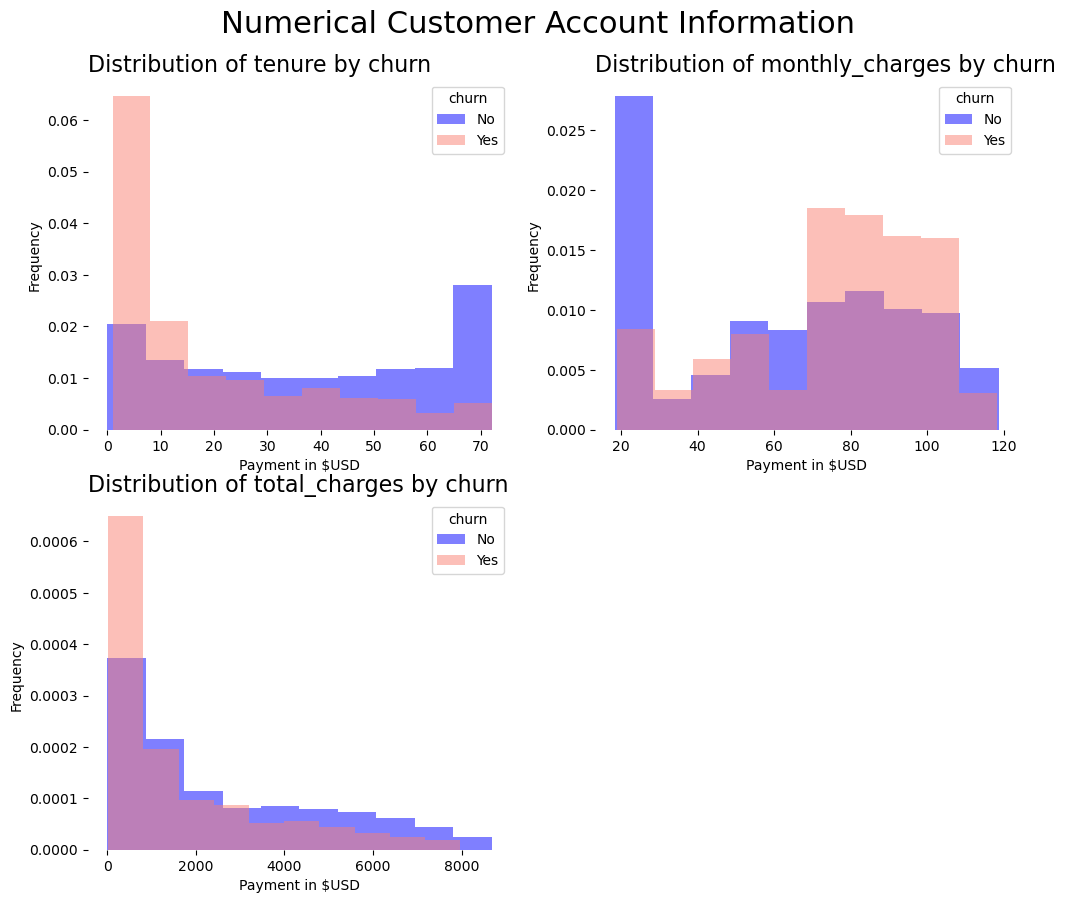

In [11]:
# Get visualizaions
explore.get_charts_num_account(train)

#### Chart Observations: Numerical Customer Account Information
* High monthly charges appear to lead to higher churn rates
* New customers apper to churn faster than long term customers
* High total charges appear to have lower churn rates
    * this is likely due to tenure of these customers more so than the higher charges 
    * total_charges is also a result of customer tenure, so we can ignore this feature

#### Statistics: Numerical Customer Account Information
Lets do some T-stats for the remaining features: tenure and monthly charges
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for tenure
Churn is catagorical, and tenure is a continuous number features so lets do a One Sample T-Test<br>
$H_0$ : The mean tenure of churned customers is = the mean tenure of all churned customers<br>
$H_a$ : The mean tenure of churned customers is != the mean tenure of all churned customers

In [12]:
# Running t-stat test
explore.get_tenure_tstat(train)

t-score = -24.280881230430392, p-value = 5.680256511980203e-105
Since the p-value is not equal to alpha, we reject Null Hypothisis
 There is a significant relationship between churn and tenure 


##### Hypothisis for monthly_charges
Churn is catagorical, and tenure is a continuous number features so lets do a One Sample T-Test <br>
$H_0$ : Mean of monthly charges of churned customers <= Mean of monthly charges of all customers<br>
$H_a$ : Mean of monthly charges of churned customers > Mean of monthly charges of all customers

In [13]:
# Running t-stat test
explore.get_monthly_charges_ttest(train)

t=12.65294490503547, p/2 = 1.0740986591134452e-34
Since p/2 > alpha and t < 0 We reject Null Hypothisis
  There is a significant relationship between churn and monthly_charges


#### Result
* Based on the results from the One Sample T-Test's and the charts, I belive numerical customer account features 'tenure' and 'monthly_charges' will have some positive effect on the model

### 4. Do any of the service features provide relevant predictive value for churn? 

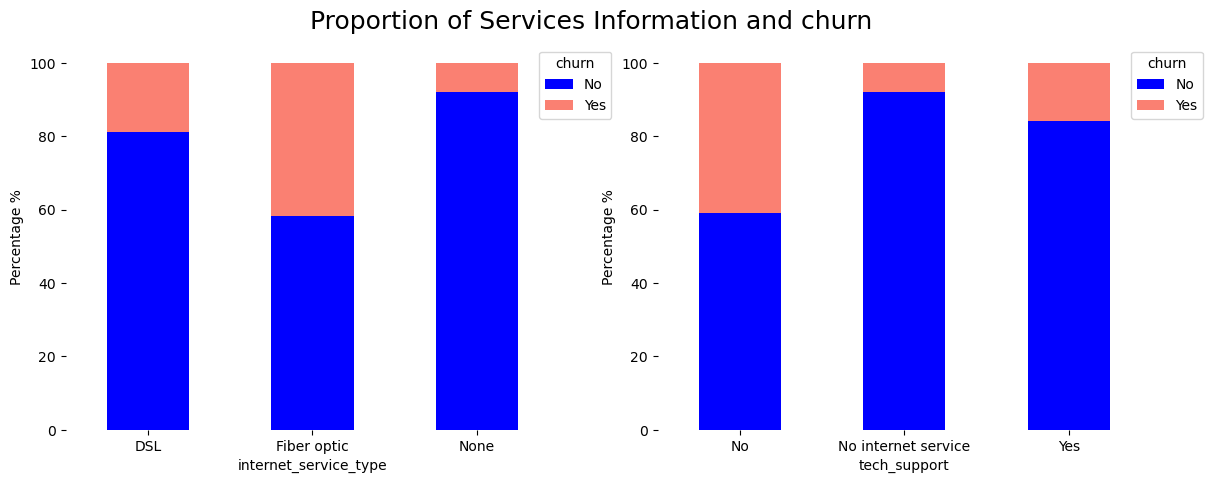

In [14]:
# Get visualizaions
explore.get_charts_services(train)

#### Chart Observations: Service Information
* phone related features seem to have no real predictive value for churn rates
* Not having tech support seems to indicate higher churn rates
* Fiber optic customers apperar to churn at a higher rate
* The other features appear to have a similar minimal impact on churn rates 
    * these features all have similar effects, perhaps they are all packaged together
    * so I will ignore them for now

####  Statistics: Service Features
Lets use $\chi^2$ for remaining service features: internet_service_type_fiber_optic and tech_support_Yes
* I will use a confidence interval of 95%
* The resulting alpha is .05

#### Hypothisis for tech_support_Yes
$H_0$ : Churn is independent of tech_support_Yes<br>
$H_a$ : Churn is dependent of tech_support_Yes

In [15]:
# Running stat test
explore.get_tech_support_Yes_chi(train)

alpha = 0.05
chi^2 = 98.2309
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the tech_support_Yes.
 Therefore, we reject the Ho


#### Hypothisis for internet_service_type_fiber_optic
$H_0$ : Churn is independent of internet_service_type_fiber_optic<br>
$H_a$ : Churn is dependent of internet_service_type_fiber_optic

In [16]:
# Running stat test
explore.get_fiber_optic_chi(train)

alpha = 0.05
chi^2 = 387.4117
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the fiber_optic.
 Therefore, we reject the Ho


#### Result
* Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'fiber_optic' and 'tech_support_Yes' will have some positive impact on the model.

## Exploration Summary
* No single group were excluvily predictive
* A combination of relevant features from each group should create a predictive model

### Features I am moving to modeling With
* 'tenure' (statistically relevent and will have a large on the model)
* 'monthly_charges' (statistically relevent and will have a modest impact on the model)
* 'partner_Yes' (statistically relevent and will have a minor positive impact on the model)
* 'dependents_Yes' (statistically relevent and will have a minor positive impact on the model)
* 'tech_support_Yes' (statistically relevent and will have a large on the model)
* 'fiber_optic' (statistically relevent and will have a large on the model)
* 'electronic_check' (statistically relevent and will have a modest impact on the model)

### Features I'm not moving to modeling with
* 'gender' (appears to be completly independent of churn)
* 'phone_service' (appears to be completly independent of churn)
* 'muliple_lines' (appears to be completly independent of churn)
* 'contract_type' (while month to month clients churn more frequently, this option is not going away so we will ignore contract stuctures)
* 'payment_type' (of all payment options only e-checks showed a relationship to churm different from the others, so all others are ignored)
* 'total_charges' (this is a function of tenure and monthly_payments, so it is ignored)
* 'online_security'(all add on services appear to have the same relationship to churn, and are perhaps included as a bundle, if so they would have an over weighted value in a model, thus they are ignored)
* 'online_backup' (all add on services appear to have the same relationship to churn, and are perhaps included as a bundle, if so they would have an over weighted value in a model, thus they are ignored)
* 'device_protection' (all add on services appear to have the same relationship to churn, and are perhaps included as a bundle, if so they would have an over weighted value in a model, thus they are ignored)
* 'streaming_tv' (all add on services appear to have the same relationship to churn, and are perhaps included as a bundle, if so they would have an over weighted value in a model, thus they are ignored)
* 'streaming_movies' (all add on services appear to have the same relationship to churn, and are perhaps included as a bundle, if so they would have an over weighted value in a model, thus they are ignored)


## Modeling

### Introduction
* I will be observing the accurracy and the recall of four models
* Recall will be the primary evaluation metric 
    * For Telco the cost of a false negative is greater than a false positives 
    * False negative being that did not spend the money on a customer that then churned.
    * False positives increase retention cost on customer that would not have churned, 
    * Cost of lost Future monthly revenue excedes retention cost

#### Baseline 
* By guessing no churn for all customers we could achieve 
    * baselines of 73.47% for accuracy and 0% fro recall

In [17]:
# get baseline accuracy and recall
explore.get_baselines()

,Metric,Score
0,Accuracy,0.734675
1,Recall,0.000000


### Four Models

In [18]:
# running 4 models with preped data for modeling, retuning accuracy and recall 
explore.get_models()

,model,set,accuracy,recall
0,k_nearest_neighbors,train,0.789586,0.452275
1,k_nearest_neighbors,validate,0.791341,0.451872
2,logistic_regression,train,0.787219,0.452275
3,logistic_regression,validate,0.786373,0.457219
4,DecisionTreeClassifier,train,0.786982,0.377342
5,DecisionTreeClassifier,validate,0.792761,0.390374
6,random_forest,train,0.784852,0.339875
7,random_forest,validate,0.786373,0.334225


### Model Selection
* All Models gave gave very similar results
    * All out performed the baseline
    * Logistic Regression gave the highest Recall on the validation set
* I will use the Logistic Regression model for the unseen Test data

### Test Model: Logistic Regression


In [19]:
explore.get_test_model()

,Model,Accuracy,Recall
0,Logistic Regression,0.811923,0.52139


### Modeling Wrap 
* On the test set the model returned a Recall of 52.14% far exceeding the baseline
    * for Reference the Acurracy exceeded the baseline by 7.72%
* This model should be used in production

## Conclusion

### Summery
* After evaluating each group of features only a few proved useful for our model
* Recall proved the best metric for evaluating various models created 
* By combining the relevant features into a series of models I found a the linear regression model was best

### Recommendations
* Implement the model provided and
* Work with marketing to form campaigns to reduce the churn rate for the company
* These programs can be offered to seperate test markets and later be evaluated to determine which is best
* Investigate reason for fiber optic customers without tech support churning faster than others

### Next Steps
* If provided more time to work on the project I would want to explore which month costomers tend to churn after converting to a month-to-month contract. This could provide insight into when is the best time to start retintion campaigns. 